In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


from tensorflow.keras.utils import to_categorical #convert to one-hot-encoding
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.optimizers import RMSprop

from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist

# Data Preparation

##  Load Data

In [3]:
x_train=pd.read_csv("C:/Users/DELL/Python learning path/Arabic Handwritten Digits/csvTrainImages 60k x 784.csv")
y_train=pd.read_csv("C:/Users/DELL/Python learning path/Arabic Handwritten Digits/csvTrainLabel 60k x 1.csv")
test_x=pd.read_csv("C:/Users/DELL/Python learning path/Arabic Handwritten Digits/csvTestImages 10k x 784.csv")
test_y=pd.read_csv("C:/Users/DELL/Python learning path/Arabic Handwritten Digits/csvTestLabel 10k x 1.csv")

#check the dimensions
print ('The shape of X is: ' + str(x_train.shape))
print ('The shape of Y is: ' + str(y_train.shape))
print ('The shape of X test is: ' + str(test_x.shape))
print ('The shape of Y test is: ' + str(test_y.shape))

The shape of X is: (59999, 784)
The shape of Y is: (59999, 1)
The shape of X test is: (9999, 784)
The shape of Y test is: (9999, 1)


#### x_train and test_x:
- Each row represents a flattened image of a handwritten digit from 0 to 9.
- Each image has been flattened into a vector of **784 values (28 × 28 pixels)**.
- The values represent **grayscale intensities**:
  - `0` for black.
  - `255` for white.

#### y_train and test_y:
- Contain the labels corresponding to the images in **x_train** and **test_x**, respectively.
- Each value is an **integer (0–9)**, representing the digit depicted in the respective image.

## Data Exploration

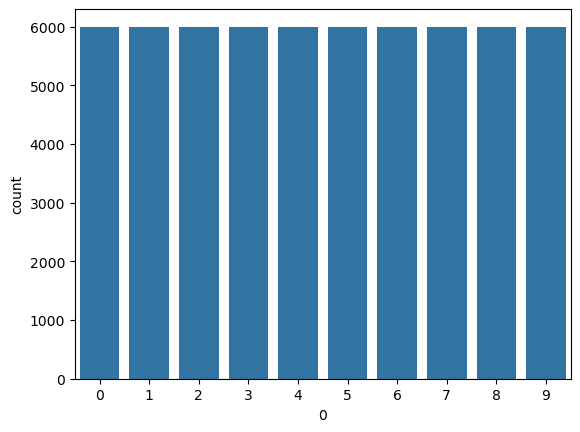

0
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
0    5999
Name: count, dtype: int64


In [6]:

y_train = y_train.squeeze() 

# Display the countplot
graph = sns.countplot(x=y_train) 
plt.show()

# Display the value counts
print(y_train.value_counts())

#### Interpretation:
The dataset is balanced, as each digit (from 0 to 9) has approximately the same number of samples in the `y_train` dataset. 

This uniform distribution ensures that the model does not become biased toward predicting any specific digit.


### check for missing data

In [4]:
# check for missing and null variables
#x_train.isnull().any().describe()
test_x.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### check for corrupted images

In [9]:
# check for corrupted images (missing values inside)

def check_for_corrupted_images(df):
    corrupted_indices = []
    for idx, row in df.iterrows():
        # Convert the row to a NumPy array for processing
        image = row.values.astype(np.float32)
        if np.isnan(image).any() or np.isinf(image).any():
            corrupted_indices.append(idx)
    return corrupted_indices

corrupted_train = check_for_corrupted_images(x_train)
corrupted_test = check_for_corrupted_images(test_x)

if corrupted_train:
    print(f"Corrupted images in training set at indices: {corrupted_train}")
else:
    print("No corrupted images found in the training set.")

if corrupted_test:
    print(f"Corrupted images in testing set at indices: {corrupted_test}")
else:
    print("No corrupted images found in the testing set.")

No corrupted images found in the training set.
No corrupted images found in the testing set.


### normalization
Dividing by 255.0 scales the values to a range between 0 and 1 because neural networks perform better when input data is scaled to a smaller range

In [3]:
#Normalization
x_train=x_train / 255.0
test_x=test_x /255.0
print ('The shape of X is: ' + str(x_train.shape))
print ('The shape of Y is: ' + str(y_train.shape))

The shape of X is: (59999, 784)
The shape of Y is: (59999, 1)


### reshape 
* The input data was initially in a 2D array of shape (n_samples, 784) where each row is a flattened 28×28 image
* To process the images with **convolutional neural networks** (designed to process multi-dimensional image data), the images need to be reshaped back into their 28×28 grid format, along with an additional channel dimension (1) for grayscale images

In [4]:
#Reshape
x_train=x_train.values.reshape(-1,28,28,1)
test_x=test_x.values.reshape(-1,28,28,1)

print ('The shape of X is: ' + str(x_train.shape))
print ('The shape of Y is: ' + str(y_train.shape))
print ('The shape of X test is: ' + str(test_x.shape))
print ('The shape of Y test is: ' + str(test_y.shape))

The shape of X is: (59999, 28, 28, 1)
The shape of Y is: (59999, 1)
The shape of X test is: (9999, 28, 28, 1)
The shape of Y test is: (9999, 1)


#### one hot encoding
One-hot encoding is a technique to convert categorical labels into a binary vector where each class label is represented by a vector with a 1 in the position of the class and 0 in all other positions
##### eg.:
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   The 4th element is 1 because the label is '3'

In [5]:
#one hot vector (encode labels)
y_train = to_categorical(y_train, num_classes = 10)
test_y  = to_categorical(test_y , num_classes = 10)
print(y_train.shape)
print(test_y.shape)

(59999, 10)
(9999, 10)


#### Visualize some samples

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


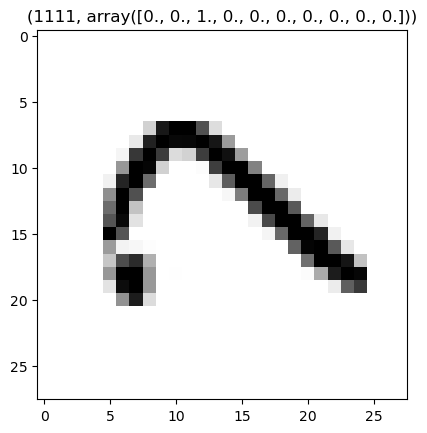

In [8]:
def display_sample(num):
    #Print this sample's label 
    label = y_train[num] 
    print(y_train[num])
    #Reshape the 784 values to a 28x28 image
    image = x_train[num]
    plt.title( (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1111)


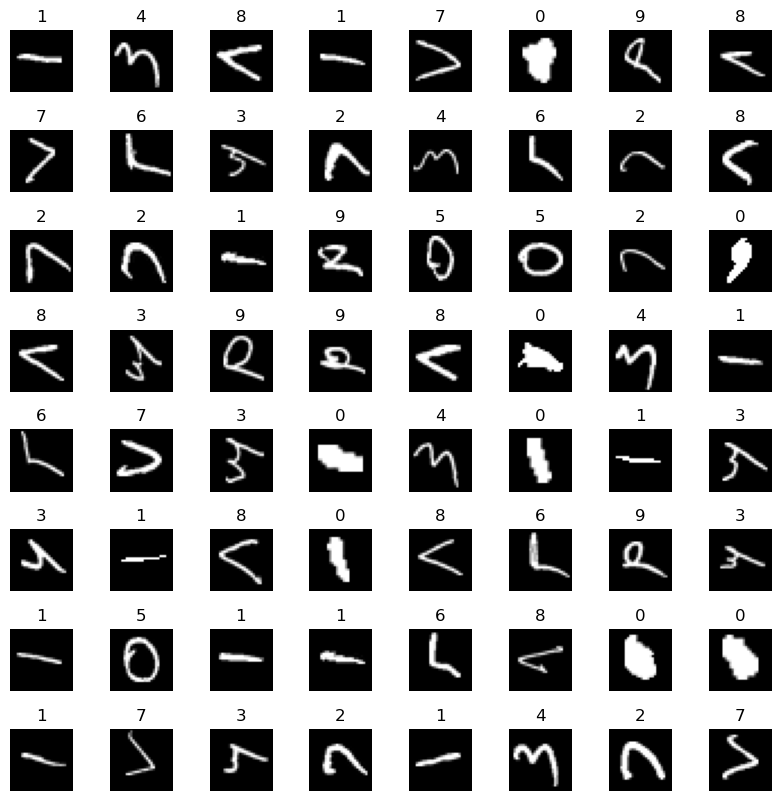

In [9]:


if len(y_train.shape) > 1:  # If y_train is 2D
    y_train_labels = np.argmax(y_train, axis=1)  # Convert to 1D labels
else:
    y_train_labels = y_train  # Already 1D

# Number of samples in the dataset
m = x_train.shape[0]  # Total number of images

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select and reshape the image
    X_random_reshaped = x_train[random_index].reshape((28, 28))  # Reshape into 28x28 (remove channel)
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(int(y_train_labels[random_index])) 
    ax.set_axis_off()


# Building Neural Network


A neural network is a computational model inspired by the human brain. It consists of layers of interconnected nodes (neurons) that process data.

- **Input**:  
  The input to the model is a grayscale image of size **28 × 28**, represented as a 3D tensor with one channel (shape `(28, 28, 1)`).

- **Convolutional Layers (7)**:  
  - Extract features from the input images by applying filters (kernels) across the image.  
  - **`padding='Same'`**: Ensures that the output size remains the same as the input size.  
  - Activation: **ReLU (Rectified Linear Unit)** replaces negative values with zero.

- **Pooling Layers (2)**:  
  - Reduces the spatial dimensions of the feature maps by selecting the maximum value in a **2 × 2** region.  
  - Helps reduce computation and overfitting.

- **Dropout Layers (3)**:  
  - Randomly drops **25%** of the neurons during training to prevent overfitting and improve generalization.

- **Flatten Layer**:  
  - Converts the 2D feature maps into a 1D vector, making it suitable for input into fully connected (dense) layers.

- **Dense Layers (2)**:  
  - The output layer has **10 neurons**, one for each digit (0–9).  
  - The **softmax activation** converts the outputs into probabilities.


In [6]:
model= Sequential([
     # Input layer with specified shape
        tf.keras.Input(shape=(28, 28, 1)),  

        # First convolutional block
        Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu'),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),

        # Output layer
        Dense(10, activation="softmax"),
    ],
    name="cnn_model"
    
)
model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,858 (3.90 MB)

 Trainable params: 1,021,706 (3.90 MB)

 Non-trainable params: 1,152 (4.50 KB)

### RMSprop (Root Mean Square Propagation)
RMSprop adjusts the learning rate for each weight dynamically to optimize performance. Below are the key parameters and their roles:

- **Learning Rate (`learning_rate=0.001`):**  
  - A small enough value to ensure stable convergence while being large enough to speed up training.

- **`rho=0.9`:**  
  - The discounting factor for the moving average of squared gradients.  
  - A higher value (close to 1) ensures the optimizer retains information about past gradients, which helps smooth optimization and adapt learning rates effectively.

- **`epsilon=1e-08`:**  
  - A small value added to the denominator to avoid division by zero during computation.

other optimizers:
* SGD (Stochastic Gradient Descent)
* Adam (Adaptive Moment Estimation)
* Adagrad (Adaptive Gradient Algorithm)
* Adadelta
* Nadam (Nesterov-accelerated Adaptive Moment Estimation)
 

In [7]:
#optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

In [8]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Learning Rate Annealer

A **learning rate annealer** gradually reduces the learning rate when the model's performance stops improving. This helps the optimizer settle into a local or global minimum by fine-tuning the training steps as progress is made.

### **Parameters**

- **`monitor='val_acc'`:**  
  The learning rate is reduced if the validation accuracy does not improve after a specified number of epochs.

- **`patience=3`:**  
  The number of epochs to wait before reducing the learning rate if no improvement is observed.

- **`verbose=1`:**  
  Enables detailed logging, showing when the learning rate is reduced and by how much.

- **`factor=0.5`:**  
  The learning rate is multiplied by this factor (0.5) when the reduction is triggered.

- **`min_lr=0.00001`:**  
  Specifies the minimum learning rate to ensure it doesn't become too small to have any meaningful effect.


In [9]:
# Set a learning rate annealer--> Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

- **Epoch:**  
  An epoch is one complete pass through the entire training dataset. During an epoch, the model processes all the training data and adjusts its weights based on the errors calculated.
- **Batch Size:**  
  The batch size refers to the number of training examples processed at once before updating the model's weights. A smaller batch size requires less memory but may result in more updates, while a larger batch size is more stable but computationally expensive.  

In [10]:
epochs = 30
batch_size = 32 

In [11]:
random_seed = 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [13]:
pred_model = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/30
1688/1688 - 148s - 88ms/step - accuracy: 0.9937 - loss: 0.0240 - val_accuracy: 0.9958 - val_loss: 0.0158
Epoch 2/30
1688/1688 - 150s - 89ms/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.9960 - val_loss: 0.0134
Epoch 3/30
1688/1688 - 151s - 89ms/step - accuracy: 0.9948 - loss: 0.0178 - val_accuracy: 0.9968 - val_loss: 0.0117
Epoch 4/30
1688/1688 - 155s - 92ms/step - accuracy: 0.9957 - loss: 0.0150 - val_accuracy: 0.9967 - val_loss: 0.0133
Epoch 5/30
1688/1688 - 151s - 90ms/step - accuracy: 0.9956 - loss: 0.0164 - val_accuracy: 0.9947 - val_loss: 0.0188
Epoch 6/30
1688/1688 - 155s - 92ms/step - accuracy: 0.9959 - loss: 0.0144 - val_accuracy: 0.9970 - val_loss: 0.0163
Epoch 7/30
1688/1688 - 153s - 91ms/step - accuracy: 0.9966 - loss: 0.0120 - val_accuracy: 0.9967 - val_loss: 0.0134
Epoch 8/30
1688/1688 - 155s - 92ms/step - accuracy: 0.9967 - loss: 0.0118 - val_accuracy: 0.9962 - val_loss: 0.0165
Epoch 9/30
1688/1688 - 158s - 94ms/step - accuracy: 0.9970 - loss: 0.011

## Model Evaluation

### Loss and Accuracy

In [16]:
loss, accuracy = model.evaluate(test_x, test_y)
print("Test data accuracy: ", accuracy)
print("Loss Funcion for test data: ", loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9932 - loss: 0.0619
Test data accuracy:  0.9917991757392883
Loss Funcion for test data:  0.06559643149375916


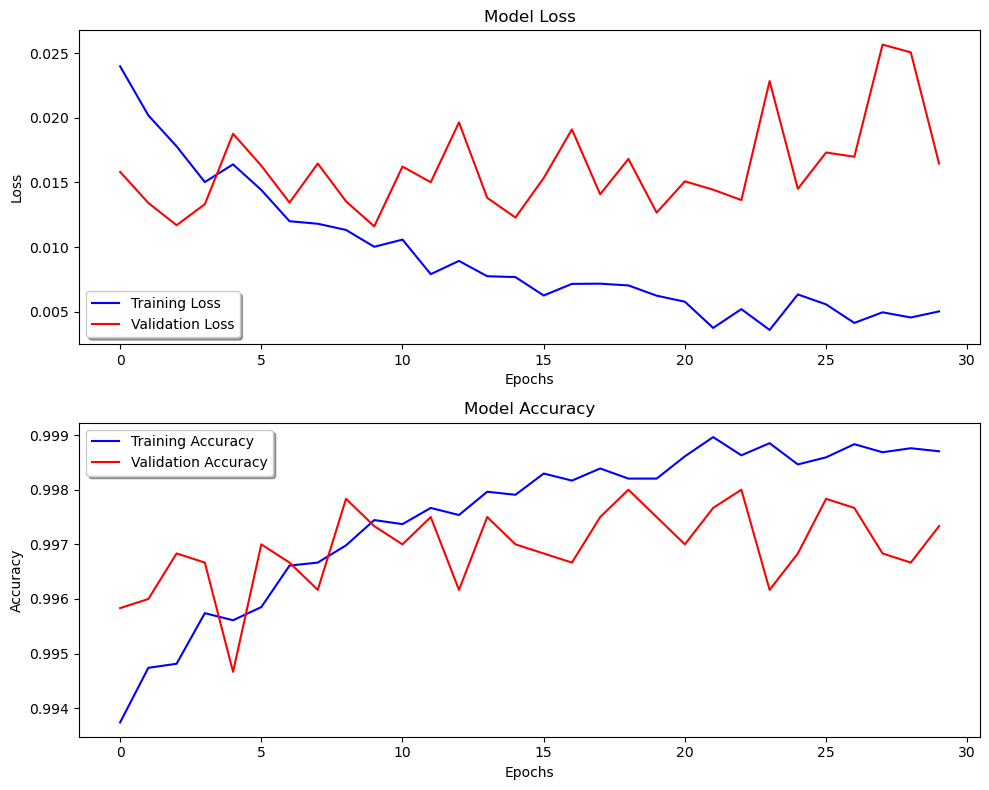

In [21]:
figure, axe = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
axe[0].plot(pred_model.history['loss'], color='b', label="Training Loss")
axe[0].plot(pred_model.history['val_loss'], color='r', label="Validation Loss")
axe[0].set_title("Model Loss")
axe[0].set_xlabel("Epochs")
axe[0].set_ylabel("Loss")
axe[0].legend(loc='best', shadow=True)
# Plot training and validation accuracy
axe[1].plot(pred_model.history['accuracy'], color='b', label="Training Accuracy")
axe[1].plot(pred_model.history['val_accuracy'], color='r', label="Validation Accuracy")
axe[1].set_title("Model Accuracy")
axe[1].set_xlabel("Epochs")
axe[1].set_ylabel("Accuracy")
axe[1].legend(loc='best', shadow=True)

# Display the plots
plt.tight_layout()
plt.show()

**Interpretation**
#### Model Loss
* Training Loss: Decreases steadily over time, indicating that the model is learning from the training data and minimizing the loss function
* Validation Loss: Initially decreases, suggesting the model is improving on unseen data.
After several epochs, it starts fluctuating and shows an upward trend, indicating potential overfitting
#### Model Accuracy
* Training Accuracy: Increases steadily and plateaus close to 1.0 (99.8%), showing the model fits the training data well.
* Validation Accuracy: Increases initially, but fluctuates after a few epochs

gives pred proba for each class for particular data point

In [22]:
y_pred= model.predict(test_x)

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step


In [23]:
y_pred.shape

(9999, 10)

In [24]:
y_pred[0]

array([4.1057737e-14, 1.0000000e+00, 7.7996128e-21, 1.2480561e-17,
       3.2168944e-20, 5.1846399e-19, 3.1460965e-18, 2.9312249e-15,
       6.8303620e-18, 7.0624603e-20], dtype=float32)

### Confusion matrix
is a tool used to evaluate the performance of a classification model by comparing predicted labels with actual labels.

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step


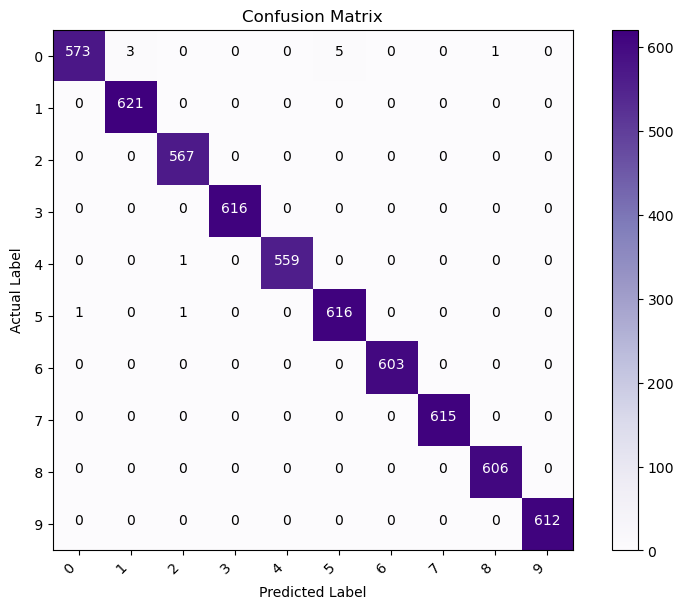

In [26]:
def display_confusion_matrix(matrix, class_names, title='Confusion Matrix', color_map=plt.cm.Purples):
    """
    Displays a confusion matrix.
    
    Parameters:
    - matrix: Confusion matrix to be displayed.
    - class_names: List of class labels.
    - title: Title of the plot.
    - color_map: Colormap to use for the visualization.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, interpolation='nearest', cmap=color_map)
    plt.title(title)
    plt.colorbar()
    
    tick_positions = np.arange(len(class_names))
    plt.xticks(tick_positions, class_names, rotation=45, ha="right")
    plt.yticks(tick_positions, class_names)
    
    threshold = matrix.max() / 2.0
    for row, col in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(
            col, row, f"{matrix[row, col]}",
            horizontalalignment="center",
            color="white" if matrix[row, col] > threshold else "black"
        )
    
    plt.tight_layout()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Make predictions on the validation set
y_pred_probabilities = model.predict(x_val)
# Convert predicted probabilities to class indices
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
# Convert true one-hot labels to class indices
y_actual_labels = np.argmax(y_val, axis=1)

# Compute the confusion matrix
confusion_matrix_result = confusion_matrix(y_actual_labels, y_pred_labels)

# Display the confusion matrix
display_confusion_matrix(
    confusion_matrix_result, 
    class_names=[f" {i}" for i in range(10)]  
)


* Diagonal Elements: These values represent the number of correctly classified samples for each class
* Off-Diagonal Elements: These values indicate misclassifications, i.e., when the model predicted the wrong class

### Some misclassified images

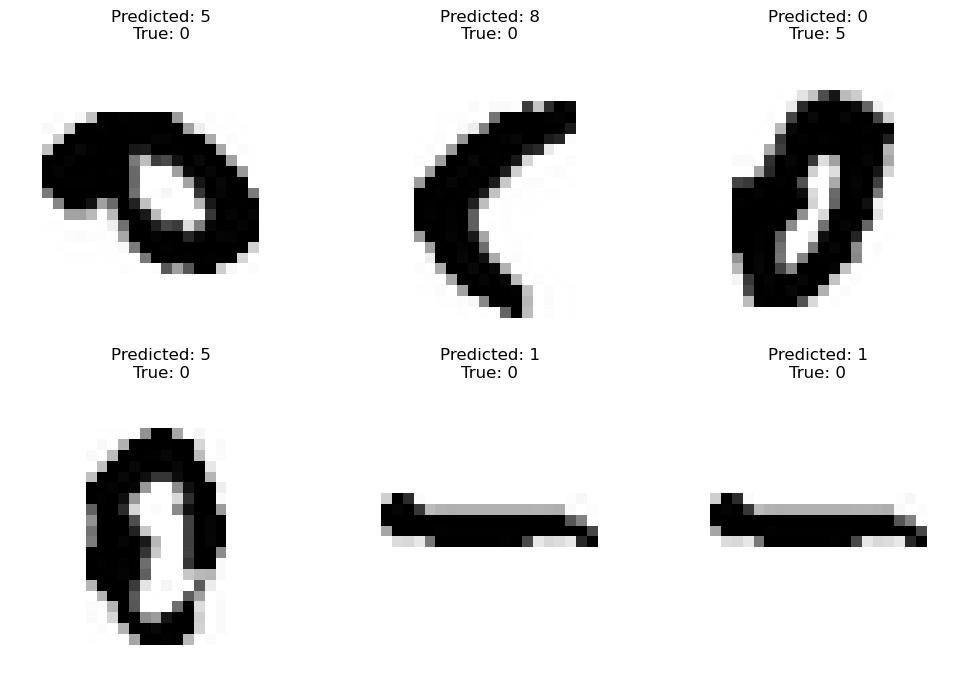

In [38]:
# Identify incorrect predictions by comparing predicted and actual labels
misclassified = (y_pred_labels != y_actual_labels)

# Extract information for misclassified examples
misclassified_predicted_labels = y_pred_labels[misclassified]
misclassified_probabilities = y_pred_probabilities[misclassified]
misclassified_true_labels = y_actual_labels[misclassified]
misclassified_images = x_val[misclassified]

# Function to display misclassified images with their labels
def show_misclassified_images(error_indices, images, predicted_labels, true_labels):
    """Displays a grid of images with their predicted and actual labels."""
    num_images = len(error_indices)
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
    
    # Ensure that the axes are iterable even for fewer images
    axes = axes.ravel()
    
    for i in range(min(num_images, rows * cols)):
        index = error_indices[i]
        axes[i].imshow(images[index].reshape(28, 28), cmap='gray_r')
        axes[i].set_title(f"Predicted: {predicted_labels[index]}\nTrue: {true_labels[index]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Calculate probabilities of the predicted labels for misclassified examples
predicted_probabilities = np.max(misclassified_probabilities, axis=1)

# Calculate probabilities corresponding to the true labels
true_label_probabilities = np.array([misclassified_probabilities[i, label] for i, label in enumerate(misclassified_true_labels)])

# Compute the difference between predicted and true label probabilities
probability_gap = predicted_probabilities - true_label_probabilities

# Sort misclassified examples by the gap between predicted and true probabilities
sorted_indices = np.argsort(probability_gap)

# Select the top 6 errors based on the largest probability gap
top_misclassified_indices = sorted_indices[-6:]

# Display the most significant errors
show_misclassified_images(top_misclassified_indices, misclassified_images, misclassified_predicted_labels, misclassified_true_labels)
